In [66]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os

try:
  os.chdir(os.path.dirname(os.path.realpath(__file__)))
except:
  pass

refineddatafolder='../Data/2-refined-data/'

signs = pd.read_csv(
  refineddatafolder + 'refined-sign-data.csv',
  parse_dates=['last_seen_at'],
  na_filter=False,
  )
roadfeatures = pd.read_csv(
  refineddatafolder + 'refined-road-data.csv',
  parse_dates=['last_seen_at'],
  na_filter=False,
  )
collisions = pd.read_csv(
  refineddatafolder + 'refined-collision-data.csv',
  parse_dates=['date_occ', 'date_rptd'],
  na_filter=False,
  )
councilshapes = gpd.read_file(
  '../Data/1-raw-data/neighborhoodcouncils.geojson',
)
councilshapes.to_crs(epsg="5070", inplace=True)
councilshapes.set_index('NAME', inplace=True)

In [2]:
nearbycouncils=[
        'GREATER WILSHIRE NC',
        'CENTRAL HOLLYWOOD NC',
        'HOLLYWOOD STUDIO DISTRICT NC',
        'MID CITY WEST CC',
        'OLYMPIC PARK NC',
        'P.I.C.O. NC',
        'WILSHIRE CENTER - KOREATOWN NC'
    ]

relevantmocodes = {
    '3003': 'Veh vs Ped',
    '3008': 'Veh vs Bike',
    '3016': 'Bike vs Veh',
    '3501': 'Ped Actions'
}

mocodenames = list(relevantmocodes.values())

# Data Examples

To show people what sort of data we have to work with

In [3]:
collisions[collisions['council'] == 'GREATER WILSHIRE NC'].sample(n=5)

,dr_no,date_rptd,date_occ,mocodes,vict_age,vict_sex,premis_desc,location,cross_street,:id,Veh vs Ped,Veh vs Bike,Bike vs Veh,Ped Actions,latitude,longitude,geometry,council,cluster
20867,150707804.0,2015-03-30,2015-03-29 22:40:00,3003 3024 3035 3036 3101 3401 3701 4027 3029,27.0,F,STREET,WILSHIRE,JUNE,row-fakq~93wr~utx2,True,False,False,False,34.0621,-118.3348,POINT (-118.3348 34.0621),GREATER WILSHIRE NC,999
3702,172011260.0,2017-05-24,2017-05-23 21:00:00,3003 3026 3035 3037 3101 3401 3701 4020,70.0,M,STREET,6TH ST,VAN NESS AV,row-4ee4~83ah.y8mw,True,False,False,False,34.0632,-118.3154,POINT (-118.3154 34.0632),GREATER WILSHIRE NC,2859
3540,120716287.0,2012-10-12,2012-10-12 21:45:00,0110 3101 3401 3701 4007 3008 3025 3035 3037,88.0,M,STREET,3RD ST,HUDSON AV,row-4bf2-bku6.nsh2,False,True,False,False,34.0689,-118.3321,POINT (-118.3321 34.0689),GREATER WILSHIRE NC,2762
1373,150715134.0,2015-09-24,2015-09-24 07:00:00,3003 3024 3034 3037 3101 3401 3701 4027,32.0,M,STREET,BEVERLY BL,DETROIT ST,row-2wrb.uc38.kezb,True,False,False,False,34.0726,-118.3393,POINT (-118.3393 34.0726),GREATER WILSHIRE NC,1223
38335,150712350.0,2015-07-18,2015-07-16 18:00:00,3003 3026 3035 3037 3101 3401 3701 4007,26.0,F,STREET,8TH ST,HIGHLAND AV,row-sdmi~zk5s~q3rs,True,False,False,False,34.0604,-118.3387,POINT (-118.3387 34.0604),GREATER WILSHIRE NC,7513


Some of these collisions either have no location data, are outside the city of LA, or fall in between the cracks of the neighborhood council boundaries in the shapefile. Filtering those out for a rough count...:

In [4]:
collisionmap = gpd.read_file(
  refineddatafolder + 'refined-collision-data.csv',
  parse_dates=['date_occ', 'date_rptd'],
  na_filter=False,
  GEOM_POSSIBLE_NAMES="geometry",
  KEEP_GEOM_COLUMNS="NO",
  crs='EPSG:6423'
)
relevantcollisions = collisionmap[
  (collisionmap['council'] != '') &
  (collisionmap.geometry.apply(str) != 'POINT (0 0)')]


In [5]:
print("Total number of accidents in LA database (including some in neighboring cities):", len(collisions))
print("Total number we can identify inside neighborhood councils:", len(relevantcollisions))
print("Total within Greater Wilshire:", len(collisions[collisions['council'] == 'GREATER WILSHIRE NC']))

sampleofcollisiondata = relevantcollisions[[
  'date_occ', 'mocodes', 'vict_age', 'vict_sex', 'Veh vs Ped', 'Veh vs Bike',
  'Bike vs Veh', 'Ped Actions', 'latitude', 'longitude', 'council'
]].sample(n=20, random_state=615)

sampleofcollisiondata

Total number of accidents in LA database (including some in neighboring cities): 50513
Total number we can identify inside neighborhood councils: 48939
Total within Greater Wilshire: 642


,date_occ,mocodes,vict_age,vict_sex,Veh vs Ped,Veh vs Bike,Bike vs Veh,Ped Actions,latitude,longitude,council
8159,2014-11-15 14:20:00,3008 3036 3024 3101 3401 3701 4026,23.0,M,False,True,False,False,34.1745,-118.5273,TARZANA NC
47755,2014-02-15 18:10:00,3003 3026 3034 3037 3101 3401 3701 4027,,M,True,False,False,False,34.1017,-118.3093,HOLLYWOOD STUDIO DISTRICT NC
29120,2017-06-19 18:35:00,3008 3026 3035 3037 3101 3401 3701 4007,55.0,M,False,True,False,False,34.0753,-118.3837,MID CITY WEST CC
47681,2019-12-13 23:50:00,4025 3036 3003 3025 3029 3101,34.0,M,True,False,False,False,34.0327,-118.3002,EMPOWERMENT CONGRESS NORTH AREA NDC
10824,2012-06-13 13:00:00,3003 3036 3026 3101 3401 3701,21.0,F,True,False,False,False,34.0444,-118.2628,DOWNTOWN LOS ANGELES
15051,2013-06-11 14:45:00,3003 3028 3101,38.0,F,True,False,False,False,33.9611,-118.2827,EMPOWERMENT CONGRESS SOUTHEAST AREA NDC
26134,2012-08-16 18:25:00,0605 3008 3035 4008 3025 3036 3101 3401 3701,,F,False,True,False,False,33.989,-118.4623,VENICE NC
1690,2020-03-21 16:00:00,3003 3037 3025 3102 4015,34.0,M,True,False,False,False,34.1684,-118.3965,NC VALLEY VILLAGE
30749,2018-11-17 14:55:00,3037 3003 3024 3101 3401 3701 4027 3034,71.0,F,True,False,False,False,34.0482,-118.4354,WESTSIDE NC
41750,2016-11-14 12:05:00,3003 3025 3034 3037 3103 3401 3701 4027,67.0,M,True,False,False,False,34.0292,-118.4107,PALMS NC


Figure out the numbers per council, and sort and label them for a graph.

In [27]:
totalsbycouncil = relevantcollisions['council'].value_counts()

squaremeterspersquaremiles = 2589988.1
squaremilesofcouncils = councilshapes.area / squaremeterspersquaremiles
collisionspersquaremile = totalsbycouncil / squaremilesofcouncils

councilcomparisons = pd.DataFrame({
  'Total Collisions': totalsbycouncil,
  'Square Miles': squaremilesofcouncils,
  'Collisions per Square Mile': collisionspersquaremile
})

maxlabellength = 30
councilcomparisons['shortcouncilname'] = councilcomparisons.index.to_series().apply(
  lambda txt: txt if len(txt) <= maxlabellength else txt[:maxlabellength] + '…'
)

councilcomparisons.sort_values(by='Collisions per Square Mile', inplace=True)

councilcomparisons


,Total Collisions,Square Miles,Collisions per Square Mile,shortcouncilname
BEL AIR-BEVERLY CREST NC,78,16.984125,4.592524,BEL AIR-BEVERLY CREST NC
FOOTHILL TRAILS DISTRICT NC,108,19.593394,5.512062,FOOTHILL TRAILS DISTRICT NC
GRANADA HILLS NORTH NC,69,11.581865,5.957590,GRANADA HILLS NORTH NC
PORTER RANCH NC,49,5.716952,8.571001,PORTER RANCH NC
SUNLAND-TUJUNGA NC,194,11.996960,16.170764,SUNLAND-TUJUNGA NC
...,...,...,...,...
CENTRAL HOLLYWOOD NC,789,1.216118,648.785704,CENTRAL HOLLYWOOD NC
DOWNTOWN LOS ANGELES,3500,5.037419,694.800314,DOWNTOWN LOS ANGELES
WILSHIRE CENTER - KOREATOWN NC,1838,2.406258,763.841584,WILSHIRE CENTER - KOREATOWN NC
MACARTHUR PARK NC,590,0.634803,929.421902,MACARTHUR PARK NC


In [95]:
# consisten region colors
colorwilshire = 'LimeGreen'
colornearby = 'DodgerBlue'
colorothers = 'LightSkyBlue'


def wilshirecolormap(pdseries):
  return [
    colorwilshire if council == "GREATER WILSHIRE NC" else
    colornearby if council in nearbycouncils else colorothers
    for council in pdseries
  ]


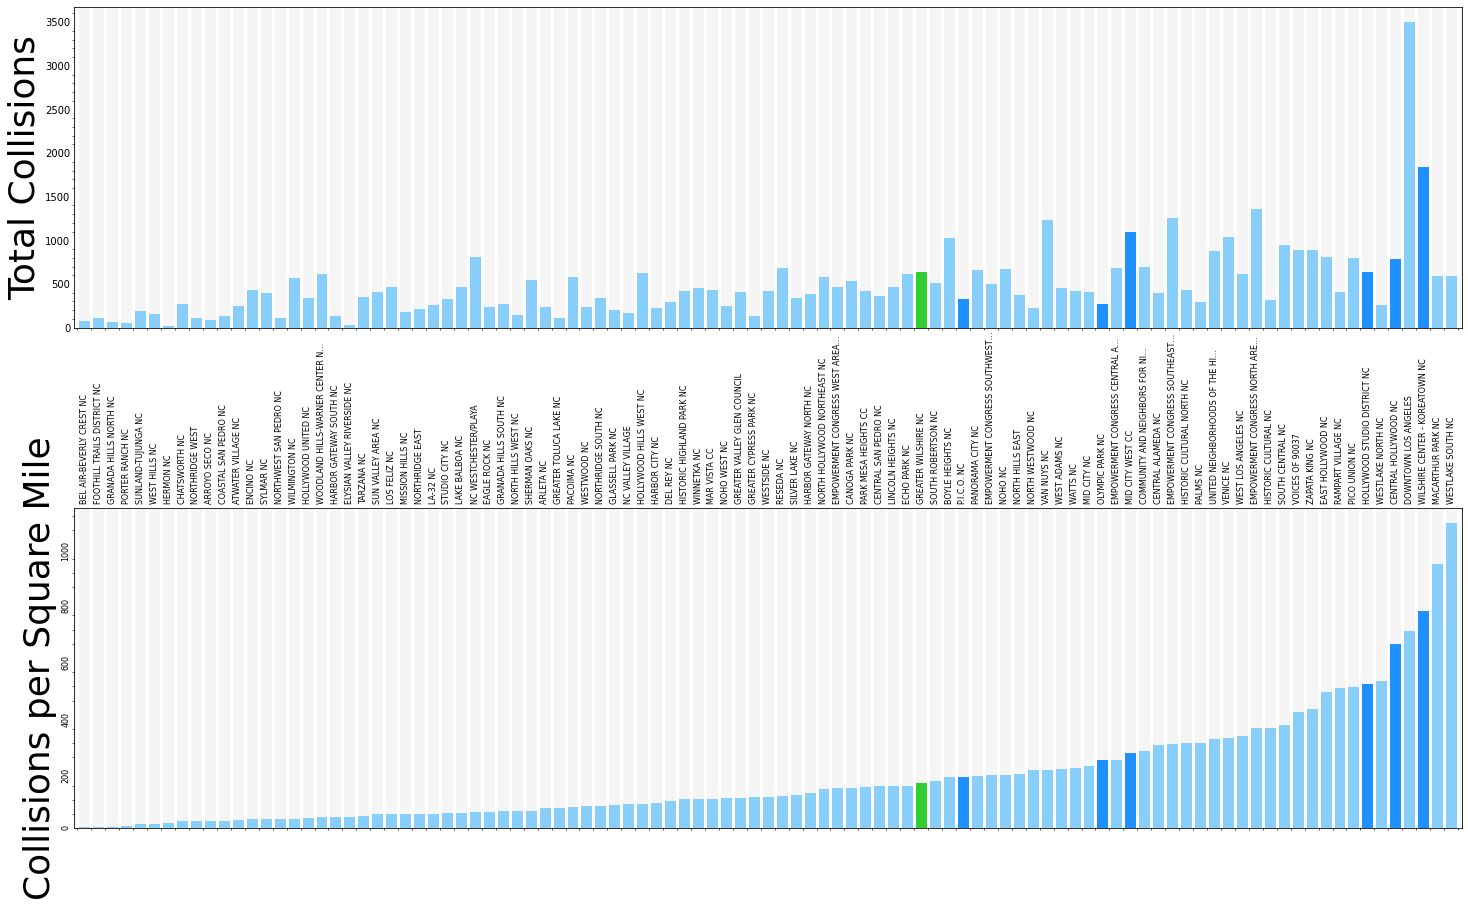

In [116]:
fig, [axtop,
      axbottom] = plt.subplots(nrows=2, figsize=(20, 12), dpi=72, sharex='col')
fig.tight_layout(h_pad=17)
plotformat = {
  'color': wilshirecolormap(councilcomparisons.index),
  'width': 1,
  'legend': None
}
councilcomparisons.plot.bar(
  'shortcouncilname',
  'Total Collisions',
  ax=axtop,
  ylabel='Total Collisions',
  **plotformat
)
councilcomparisons.plot.bar(
  'shortcouncilname',
  'Collisions per Square Mile',
  ax=axbottom,
  ylabel='Collisions per Square Mile',
  **plotformat
)

axbottom.tick_params(
  labelsize=8, labeltop=True, labelbottom=False, labelrotation=90
)

for ax in [axtop, axbottom]:
  ax.yaxis.label.set_size(36)
  ax.margins(x=0)
  ax.minorticks_on()
  ax.set_facecolor('WhiteSmoke')
  ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
  ax.tick_params(length=0)
  ax.tick_params(axis='x', which='minor', grid_color='white', grid_linewidth=3)
  ax.grid(True, axis='x', which='minor')
  ax.set(xlabel=None)


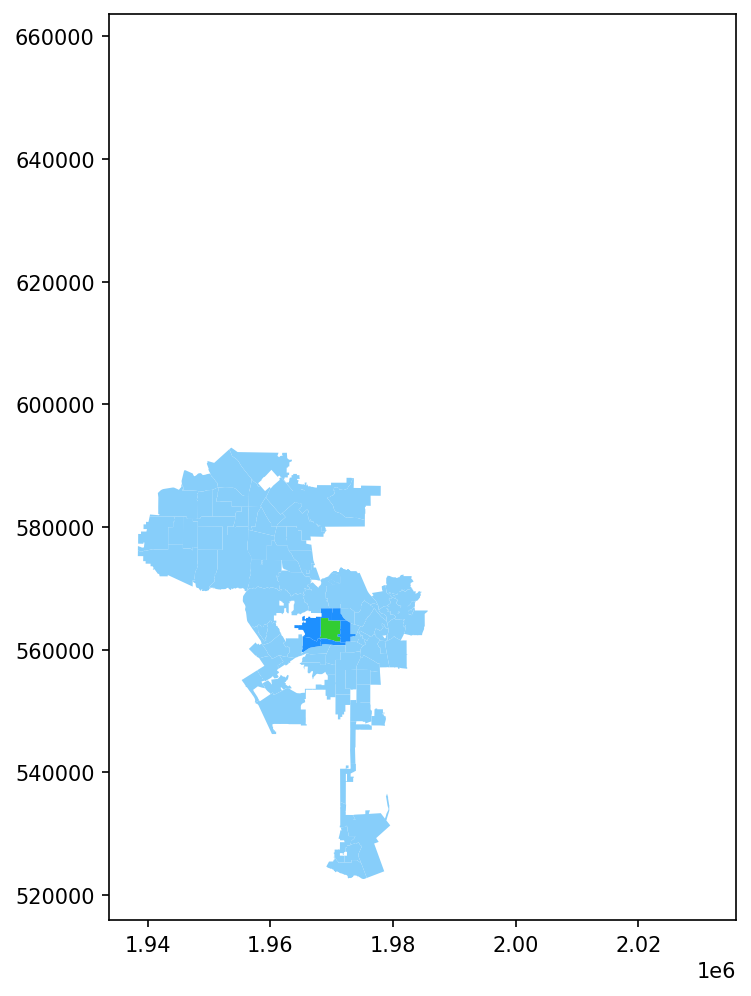

In [128]:
coloredmap = councilshapes.to_crs(epsg='6423').plot(color=wilshirecolormap(councilshapes.index), figsize=(8,8))

coloredmap.get_figure().set_dpi(150)


In [97]:
councilshapes

,OBJECTID,WADDRESS,DWEBSITE,DEMAIL,DPHONE,NC_ID,CERTIFIED,TOOLTIP,NLA_URL,SERVICE_RE,geometry
NAME,,,,,,,,,,,
ARLETA NC,1,http://www.arletanc.org/,http://empowerla.org/ANC,ANC@EmpowerLA.org,213-978-1551,6,2002-10-22T00:00:00+00:00,ARLETA NC,navigatela/reports/nc_reports.cfm?id=6,REGION 1 - NORTH EAST VALLEY,"POLYGON ((-2032901.721 1484154.555, -2032789.3..."
ARROYO SECO NC,2,http://www.asnc.us/,http://empowerla.org/ASNC,ASNC@EmpowerLA.org,213-978-1551,42,2002-10-02T00:00:00+00:00,ARROYO SECO NC,navigatela/reports/nc_reports.cfm?id=42,REGION 8 - NORTH EAST LA,"POLYGON ((-2016523.692 1463452.474, -2016647.6..."
ATWATER VILLAGE NC,3,http://www.atwatervillage.org/,http://empowerla.org/AVNC,AVNC@EmpowerLA.org,213-978-1551,37,2003-02-11T00:00:00+00:00,ATWATER VILLAGE NC,navigatela/reports/nc_reports.cfm?id=37,REGION 7 - EAST,"POLYGON ((-2019906.510 1469985.927, -2020291.8..."
BEL AIR-BEVERLY CREST NC,4,http://babcnc.org/,http://empowerla.org/BABCNC,BABCNC@EmpowerLA.org,213-978-1551,64,2002-10-08T00:00:00+00:00,BEL AIR-BEVERLY CREST NC,navigatela/reports/nc_reports.cfm?id=64,REGION 11 - WEST LA,"POLYGON ((-2038342.125 1471256.262, -2038411.9..."
BOYLE HEIGHTS NC,5,http://bhnc.net/,http://empowerla.org/BHNC,BHNC@EmpowerLA.org,213-978-1551,50,2002-05-21T00:00:00+00:00,BOYLE HEIGHTS NC,navigatela/reports/nc_reports.cfm?id=50,REGION 8 - NORTH EAST LA,"POLYGON ((-2016855.550 1458556.797, -2017125.1..."
...,...,...,...,...,...,...,...,...,...,...,...
WILMINGTON NC,95,http://www.wilmingtonneighborhoodcouncil.com/,http://empowerla.org/WILMINGTON,WilmingtonNC@EmpowerLA.org,213-978-1551,93,2001-12-11T00:00:00+00:00,WILMINGTON NC,navigatela/reports/nc_reports.cfm?id=93,REGION 12 - HARBOR,"POLYGON ((-2029783.517 1431496.741, -2029839.8..."
WILSHIRE CENTER - KOREATOWN NC,96,http://wcknc.org/,http://empowerla.org/WCKNC,WCKNC@EmpowerLA.org,213-978-1551,55,2003-08-05T00:00:00+00:00,WILSHIRE CENTER - KOREATOWN NC,navigatela/reports/nc_reports.cfm?id=55,REGION 6 - CENTRAL 2,"POLYGON ((-2023237.907 1462324.733, -2023770.0..."
WINNETKA NC,97,http://www.winnetkanc.com/,http://empowerla.org/WINNETKA,WinnetkaNC@EmpowerLA.org,213-978-1551,14,2003-07-22T00:00:00+00:00,WINNETKA NC,navigatela/reports/nc_reports.cfm?id=14,REGION 3 - SOUTH WEST VALLEY,"POLYGON ((-2045586.406 1485556.487, -2046674.5..."


# Yearly Totals
Looking at collisions in neighborhood councils by year

In [ ]:
yearlycollisions = collisions.groupby(collisions['date_occ'].dt.year)
ncyearly = yearlycollisions['council'].value_counts().unstack()

## Greater Wilshire Alone - Totals

[Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '73'),
 Text(0, 0, '83'),
 Text(0, 0, '62'),
 Text(0, 0, '81'),
 Text(0, 0, '83'),
 Text(0, 0, '74'),
 Text(0, 0, '63'),
 Text(0, 0, '63'),
 Text(0, 0, '44'),
 Text(0, 0, '16')]

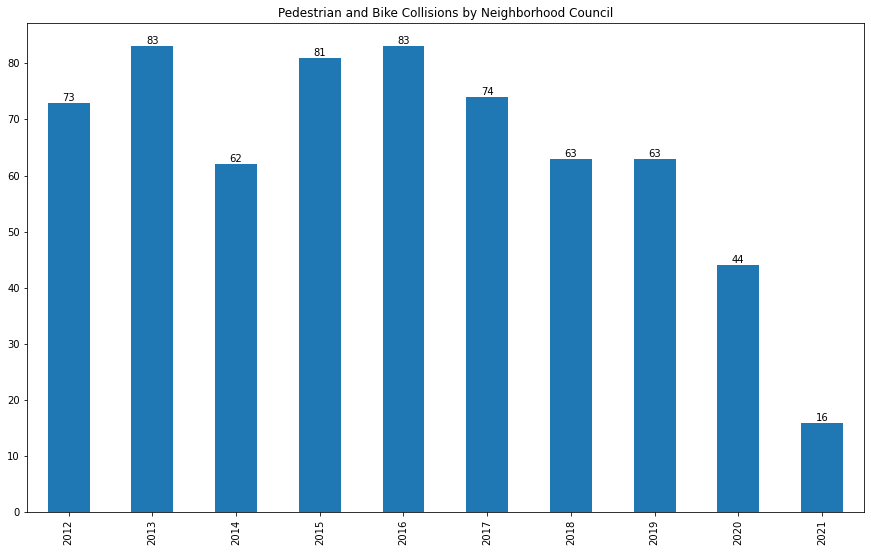

In [ ]:
wilshirechart = ncyearly['GREATER WILSHIRE NC'].plot.bar(
  title="Pedestrian and Bike Collisions by Neighborhood Council",
  figsize=(15, 9),
  xlabel='',
)
xmin, xmax = wilshirechart.get_xlim()
wilshirechart.set_xlim([xmin + 2, xmax])
wilshirechart.bar_label(wilshirechart.containers[0])


## Greater Wilshire and Nearby Council Areas - Totals

(1.5, 11.5)

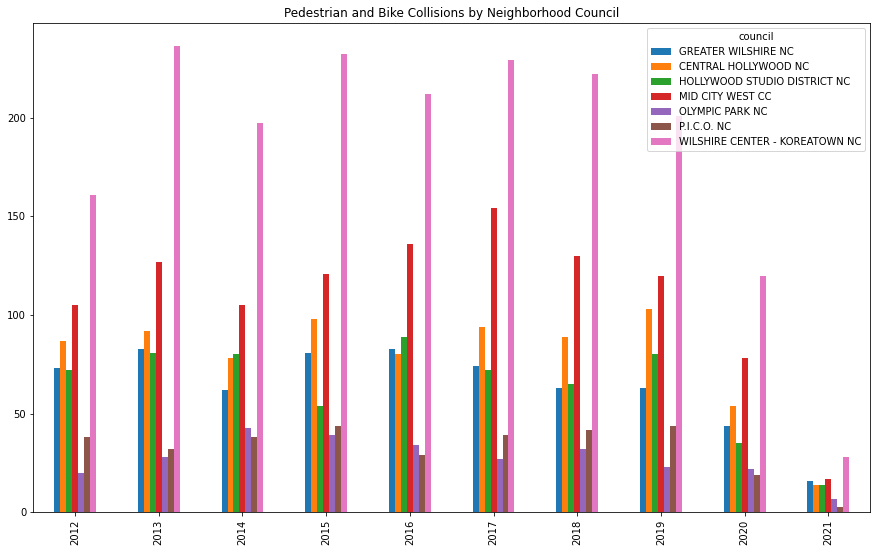

In [ ]:
groupchart = ncyearly[nearbycouncils].plot.bar(
  title="Pedestrian and Bike Collisions by Neighborhood Council",
  figsize=(15, 9),
  xlabel='',
)
xmin, xmax = groupchart.get_xlim()
groupchart.set_xlim([xmin + 2, xmax])

## Totals per Square Foot

In [ ]:
# Convert to map projection for LA County to calculate areas
councilshapes['square meters'] = councilshapes.area
councilshapes['sf'] = councilshapes['square meters'].multiply(10.76391)


ncyearlyadjusted = yearlycollisions['council'].value_counts().unstack()
for nc in ncyearlyadjusted:
  if (nc in councilshapes.NAME):
    ncyearlyadjusted[nc] = ncyearlyadjusted[nc] / councilshapes['sf'][nc]


groupchartadjusted = ncyearlyadjusted[nearbycouncils].plot.bar(
  title="Pedestrian and Bike Collisions per SF by Neighborhood Council",
  figsize=(15, 9),
  xlabel='',
)
xmin, xmax = groupchartadjusted.get_xlim()
groupchartadjusted.set_xlim([xmin + 2, xmax])


AttributeError: 'GeoDataFrame' object has no attribute 'NAME'

## Incidents by Time of Day

<AxesSubplot:title={'center':'Collisions by Time of Day - Greater Wilshire'}>

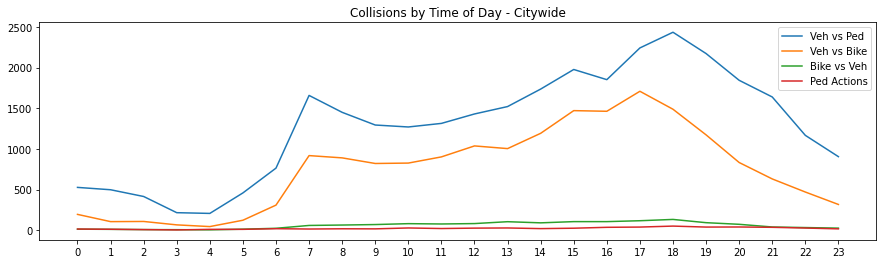

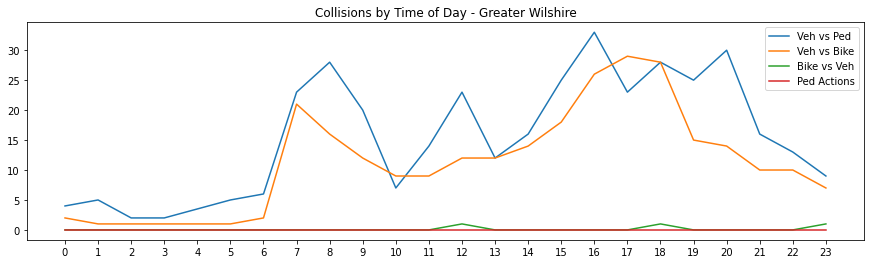

In [ ]:
timeofday = collisions.groupby(collisions['date_occ'].dt.hour)
timeofday[mocodenames].sum().plot(
  title='Collisions by Time of Day - Citywide',
  xlabel='',
  xticks=range(0, 24),
  figsize=(15, 4)
)

timeofday = collisions[collisions['council'] == 'GREATER WILSHIRE NC'].groupby(collisions['date_occ'].dt.hour)
timeofday[mocodenames].sum().plot(
  title='Collisions by Time of Day - Greater Wilshire',
  xlabel='',
  xticks=range(0, 24),
  figsize=(15, 4)
)


# Statistics by cluster
Group by cluster, count each type of incident, and calculate a central GPS coordinate for each cluster.

In [ ]:
wilshirecollisions = collisions[collisions.council.isin(nearbycouncils)].copy()
wilshirecollisionintersections = wilshirecollisions.groupby('cluster')
wilshireintersectioncoordinates = wilshirecollisionintersections[['longitude', 'latitude']].mean()
totalsbyintersection: pd.DataFrame = wilshirecollisionintersections[
  mocodenames
].sum()

totalsbyintersection['Total Collisions'] = totalsbyintersection.sum(axis=1)
totalsgeoframe: gpd.GeoDataFrame = totalsbyintersection.set_geometry(
  gpd.points_from_xy(wilshireintersectioncoordinates['longitude'], wilshireintersectioncoordinates['latitude'])
)


### Save intersection cluster statistics for QGIS;

In [ ]:
totalsgeoframe.to_csv(refineddatafolder+'qgis-clustered-collision-counts.csv', index=False)

### Map the clusters

In [ ]:
import folium

wilshiremap = folium.Map(
  location=(34.0689, -118.3386), tiles='OpenStreetMap', min_zoom=13
)

sw = wilshireintersectioncoordinates[['latitude',
  'longitude']].min().values.tolist()
ne = wilshireintersectioncoordinates[['latitude',
  'longitude']].max().values.tolist()
wilshiremap.fit_bounds([sw, ne])

colorcode = folium.StepColormap(["yellow", "pink", "red", "darkred"], vmin=1, vmax=totalsgeoframe['Total Collisions'].max())

for i, row in totalsgeoframe.iterrows():
  gpspoint = row['geometry']
  color = colorcode(row['Total Collisions'])
  label = row['Total Collisions']
  folium.Marker(
    [gpspoint.y, gpspoint.x],
    tooltip='<br />'.join([
      f'gps: {gpspoint}',
      row.to_frame().to_html()
    ]),
    icon=folium.DivIcon(
      html=f'<span style="color: {color}; background-color :white">—{label}-</span>'
    )
  ).add_to(wilshiremap)

wilshiremap


# Notes

Some of the collision data fell on the border between two districts, and the shapefile join didn't pick up on them. Not that important for this analysis but might be an issue in other neighborhoods.

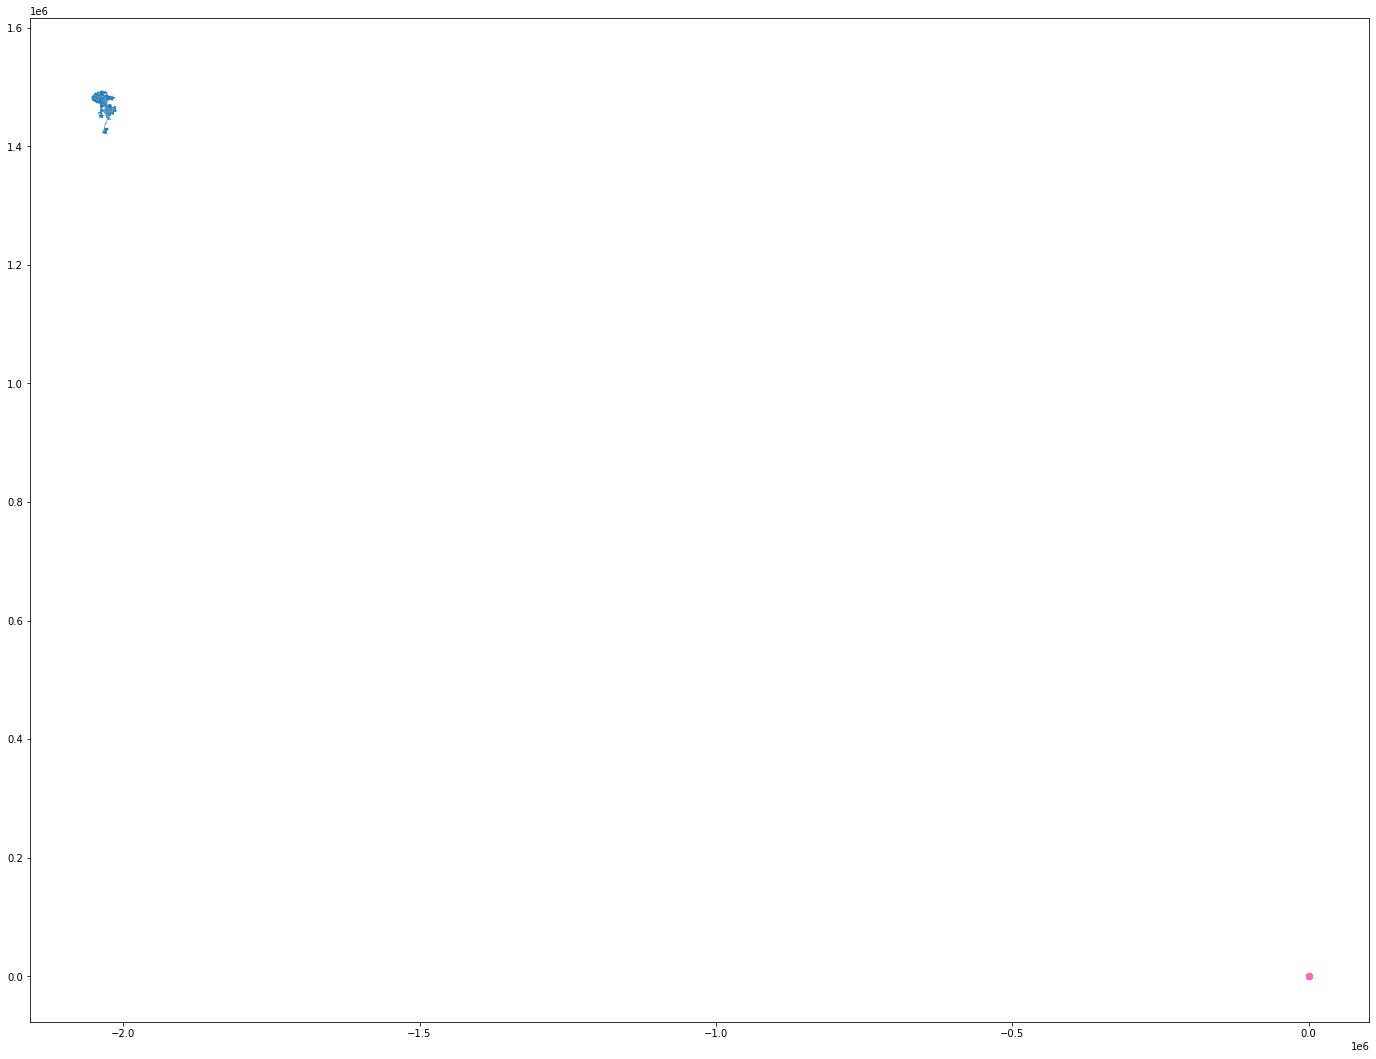

In [ ]:

unrecognizedplaces = collisionmap[
  (collisionmap['council'] == '') &
  (collisionmap.geometry.apply(str) != 'POINT (0 0)')]

ax = councilshapes.plot(figsize=(24, 24))
overlay = unrecognizedplaces.plot(ax=ax, color='HotPink')
